# Primal-Dual Algorithm for Image Segmentation

In [258]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pylops
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.segmentation import *
# from scripts.Segment_ import *
from numba import cuda
# from scripts._Simplex_numba_ import *

import time
import numpy as np
from pylops import Gradient, BlockDiag
from pyproximal import Simplex, L1, L21, VStack
from pyproximal.optimization.primaldual import PrimalDual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# data Loading

m_true = np.load('data/m_true.npy')
m1 = np.load('data/mpd3a.npy')
m2 = np.load('data/mpd3b.npy')
dif = m2 - m1

vmin, vmax =  m1.min(), m1.max()

## Example 1: Segmentation of time-lapse difference of subsurface models

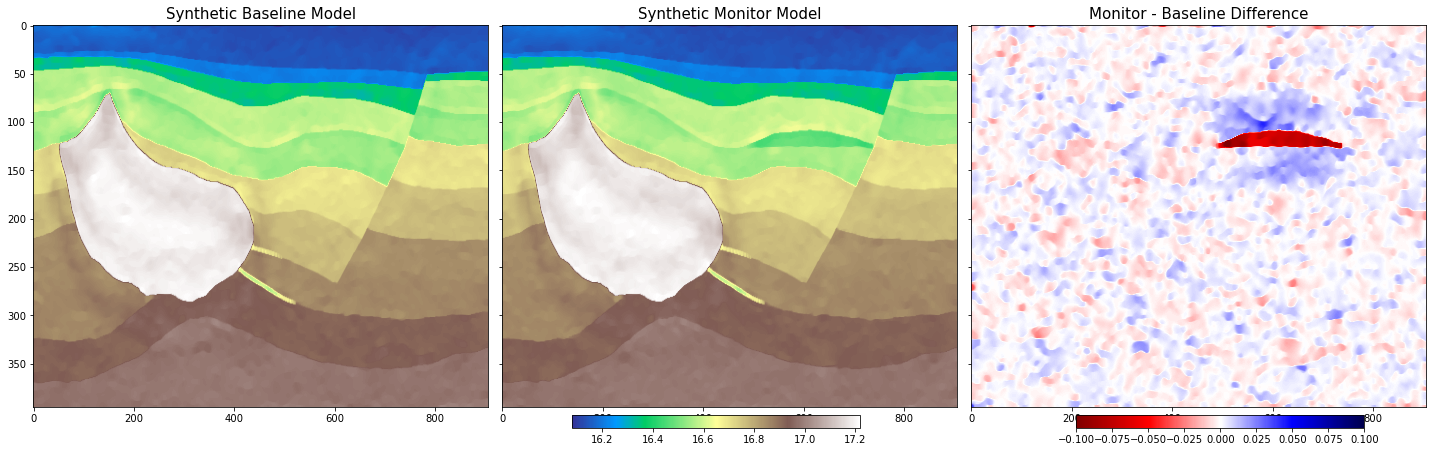

In [3]:
fig, ax = plt.subplots(1,3, figsize=(20,6), sharey=True)
ax = ax.flatten()
ax0 = ax[0].imshow(m1, vmin=vmin,  vmax=vmax, cmap='terrain')
ax[0].set_title('Synthetic Baseline Model', fontsize=15)
ax[0].axis('tight');
ax[1].imshow(m2, vmin=vmin, vmax=vmax, cmap='terrain')
ax[1].set_title('Synthetic Monitor Model', fontsize=15)
ax[1].axis('tight');
ax2=ax[2].imshow(dif, vmin=-0.1, vmax=0.1, cmap='seismic_r')
ax[2].set_title('Monitor - Baseline Difference', fontsize=15)
ax[2].axis('tight');
fig.tight_layout()
fig.subplots_adjust(bottom=0.5)
cbar_ax = fig.add_axes([0.4, 0.001, 0.2, 0.03])
fig.colorbar(ax0, cax=cbar_ax, orientation='horizontal')
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.75, 0.001, 0.2, 0.03])
fig.colorbar(ax2, cax=cbar_ax, orientation='horizontal')

In [255]:
# colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)] 
# cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
# cl    = np.array([-0.05,0, 0.05])
# sigma = 1.
# alpha = 0.001

# segpd, segpd_classes = \
#     Segment(dif, cl, sigma, alpha, niter=50, show=True, 
#             kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

# fig, ax = plt.subplots(1,2, figsize=(20,5)) 
# im0 = ax[0].imshow(dif, cmap='seismic', vmin = -0.1, vmax = 0.1)
# ax[0].axis('tight');
# ax[0].set_title('Impedance difference')   
# im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
# ax[1].axis('tight');
# ax[1].set_title('Segmentation result') 
# fig.colorbar(im0, ax=ax[0], orientation='vertical')
# fig.colorbar(im1, ax=ax[1], orientation='vertical')
# plt.show() 

## Example 2: Segmentation of subsurface model

In [256]:
# allcl = np.unique(m_true)
# nclmin = 3000 #10000
# cl = np.array(list(filter(lambda x: np.count_nonzero(m_true.ravel() == x) > nclmin, allcl)))
# ncl = len(cl)

# segpd, segpd_classes = \
#     Segment(m1, cl, 20., 0.2, niter=50, show=True, 
#             kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))


In [257]:
# fig, ax = plt.subplots(1,2, figsize=(20,5)) 
# ax0 = ax[0].imshow(m1, vmin=vmin,  vmax=vmax, cmap='terrain')
# ax[0].axis('tight');
# ax[0].set_title('Impedance difference')   
# im1 = ax[1].imshow(segpd_classes, cmap='Pastel1', vmin=-0.5, vmax=ncl-0.5,)
# ax[1].axis('tight');
# ax[1].set_title('Segmentation result') 
# fig.colorbar(im0, ax=ax[0], orientation='vertical')
# fig.colorbar(im1, ax=ax[1], orientation='vertical')
# plt.show() 

## Session September 5th

In [4]:
def PrimalDual_(proxf, proxg, A, x0, tau, mu, z=None, theta=1., niter=10,
               gfirst=True, callback=None, callbacky=False, show=False):

    x = x0.copy()
    xhat = x.copy()
    y = np.zeros(A.shape[0], dtype=x.dtype)

    for iiter in range(niter):
        xold = x.copy()
        y = proxg.proxdual(y + mu * A.matvec(xhat), mu)
        ATy = A.rmatvec(y)
        if z is not None:
            ATy += z
        x = proxf.prox(x - tau * ATy, tau)
        xhat = x + theta * (x - xold)


    return x, (x - tau * ATy)

In [259]:
def Segment1(y, cl, sigma, alpha, clsigmas=None, z=None, niter=10, x0=None,
            callback=None, show=False, kwargs_simplex=None):
 
    kwargs_simplex = {} if kwargs_simplex is None else kwargs_simplex

    dims = y.shape
    ndims = len(dims)
    dimsprod = np.prod(np.array(dims))
    ncl = len(cl)

    # Data (difference between image and center of classes)
    g = sigma / 2. * (y.reshape(1, dimsprod) - cl[:, np.newaxis]) ** 2
    if clsigmas is not None:
        g /= clsigmas[:, np.newaxis]
    g = g.ravel()

    # Gradient operator
    sampling = 1.
    Gop = Gradient(dims=dims, sampling=sampling, edge=False,
                   kind='forward', dtype='float64')
    Gop = BlockDiag([Gop] * ncl)

    # Simplex and L1 proximal operators
    simp = Simplex(dimsprod * ncl, radius=1, dims=(ncl, dimsprod), axis=0,
                   **kwargs_simplex)
    #l1 = L1(sigma=0.5 * alpha)
    l21 = VStack([L21(ndim=ndims, sigma=0.5 * alpha)] * ncl,
                 nn=[ndims * dimsprod] * ncl)

    # Steps
    L = 8. / sampling ** 2
    tau = 1.
    mu = 1. / (tau * L)

    # Inversion
    x, y = PrimalDual_(simp, l21, Gop, tau=tau, mu=mu,
                   z=g if z is None else g + z, theta=1.,
                   x0=np.zeros_like(g) if x0 is None else x0,
                   niter=niter, callback=callback, show=show)
    x = x.reshape(ncl, dimsprod).T
    cl = np.argmax(x, axis=1)
    cl = cl.reshape(dims)

    return y

This cell is intended to produced the segmentation matrix after one iteration to later use it in the segmentation(gpu version)

In [6]:
colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)] 
cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
cl    = np.array([-0.05,0, 0.05])
sigma = 1.
alpha = 0.001

y = \
    Segment1(dif, cl, sigma, alpha, niter=1, show=True, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

# fig, ax = plt.subplots(1,2, figsize=(20,5)) 
# im0 = ax[0].imshow(dif, cmap='seismic', vmin = -0.1, vmax = 0.1)
# ax[0].axis('tight');
# ax[0].set_title('Impedance difference')   
# im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
# ax[1].axis('tight');
# ax[1].set_title('Segmentation result') 
# fig.colorbar(im0, ax=ax[0], orientation='vertical')
# fig.colorbar(im1, ax=ax[1], orientation='vertical')
# plt.show() 

In [9]:
y.shape

(1072425,)

In [81]:
# @cuda.jit(device=True)
def fun_jit(mu, x, coeffs, scalar, lower, upper):
    """Bisection function"""
    return np.dot(coeffs, np.min(np.max(x - mu * coeffs, lower), upper)) - scalar


In [82]:
# @cuda.jit(device=True)
def bisect_jit_(x, coeffs, scalar, lower, upper, bisect_lower, bisect_upper,
               maxiter, ftol, xtol):
    
    a, b = bisect_lower, bisect_upper
    fa = fun_jit(a, x, coeffs, scalar, lower, upper)
    for iiter in range(maxiter):
        c = (a + b) / 2.
        if (b - a)/2 < xtol:
            return c
        fc = fun_jit(c, x, coeffs, scalar, lower, upper)
        if np.abs(fc) < ftol:
            return c
        if np.sign(fc) == np.sign(fa):
            a = c
            fa = fc
        else:
            b = c
    return c

In [80]:
def simplex_jit_(x, coeffs, scalar, lower, upper, maxiter, ftol, xtol):
    y = np.zeros_like(x)
    
    for i in range(x.shape[0]):
        
        bisect_lower = -1
        while fun_jit(bisect_lower, x[i], coeffs, scalar, lower, upper) < 0:
        
            bisect_lower *= 2
        bisect_upper = 1
        while fun_jit(bisect_upper, x[i], coeffs, scalar, lower, upper) > 0:
            bisect_upper *= 2
            
        c = bisect_jit_(x[i], coeffs, scalar, lower, upper,
                       bisect_lower, bisect_upper, maxiter, ftol, xtol)
        
        y[i] = np.min(np.max(x[i] - c * coeffs, lower), upper)
    return y

In [ ]:
@cuda.jit
def bisection_gpu(x, coeffs, scalar, lower, upper, maxiter, ftol, xtol, c):
    
    i, j = cuda.grid(2)
    size = x.shape[0]
    size1 = x.shape[1]

    if i < size and j < size1:
    
        bisect_lower = -1
        while fun_jit(bisect_lower, x[i], coeffs, scalar, lower, upper) < 0:
#             (mu, x, coeffs, scalar, lower, upper):
#         while np.dot(coeffs, np.minimum(np.maximum(x - mu * coeffs, lower), upper)) - scalar < 0:    
            
            bisect_lower *= 2
        bisect_upper = 1
        while fun_jit(bisect_upper, x[i], coeffs, scalar, lower, upper) > 0:
            bisect_upper *= 2
            
        c[i] = bisect_jit_(x[i], coeffs, scalar, lower, upper,
                       bisect_lower, bisect_upper, maxiter, ftol, xtol)
        
        max_= np.max(x[i,j] - c[i,j], lower)
        y[i,j] = np.min(max_, upper)
    return y

In [11]:
dims = dif.shape
ndims = len(dims)
dimsprod = np.prod(np.array(dims))
cl    = np.array([-0.05,0, 0.05])
ncl = len(cl)
coeff = np.ones(3)
z  = y.reshape((ncl, dimsprod))
z.shape

(3, 357475)

In [12]:
x = z.T
# y = simplex_jit_(x, coeff, 1, 0, 10000000000,
#                 10, 1e-8, 1e-8)
# y = y.T

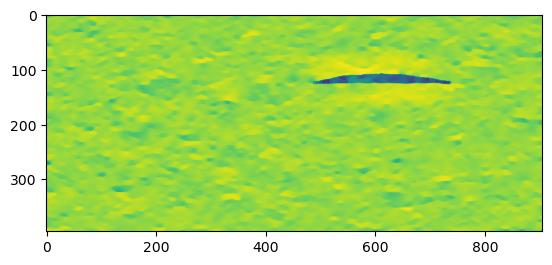

In [103]:
plt.imshow(y.reshape((3,395,905))[2]);

In [240]:
@cuda.jit
def bisection_gpu(x1, x2, c):
    c[0] = x1 + x2 

In [241]:
c = np.zeros(1)
bisection_gpu[1, 1](1, 2, c)

/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [69]:
print(c)

[3.]


In [72]:
x_test = cuda.to_device(np.copy(x))
y = cuda.device_array_like(x_test)

### Experimentation with a simpler example

In [262]:
def test_gpu(A):
    B = np.empty_like(A)
    for i in range(A.shape[0]):
        B[i] = A[i] * 2
    return B

In [145]:
A = np.array(np.random.random(100).reshape((10,10)), dtype=np.float32)
A

array([[0.86332244, 0.4203805 , 0.71597266, 0.24069762, 0.07100683,
        0.27576682, 0.49441445, 0.08476014, 0.17176746, 0.79182786],
       [0.2109162 , 0.29284632, 0.44620875, 0.46423036, 0.9584762 ,
        0.84137356, 0.05330093, 0.01750445, 0.6504384 , 0.9466352 ],
       [0.67197186, 0.6180561 , 0.03660068, 0.93857557, 0.13574736,
        0.5034753 , 0.8484206 , 0.22196151, 0.452128  , 0.20121205],
       [0.927537  , 0.592467  , 0.47901797, 0.7653692 , 0.8754787 ,
        0.10382645, 0.6380528 , 0.28902045, 0.65822005, 0.54335713],
       [0.7182116 , 0.24807951, 0.28688878, 0.8173762 , 0.71542984,
        0.29912928, 0.7163112 , 0.30684957, 0.48840594, 0.68808395],
       [0.5856467 , 0.62798953, 0.7456309 , 0.7674444 , 0.10574208,
        0.13910118, 0.9714005 , 0.76717067, 0.7970881 , 0.83518   ],
       [0.096137  , 0.49876225, 0.15258846, 0.8216889 , 0.55593735,
        0.96788806, 0.46283603, 0.6197786 , 0.236394  , 0.6083648 ],
       [0.13713211, 0.49414515, 0.7995879

In [263]:
test_gpu(A)

array([[1.7266449 , 0.840761  , 1.4319453 , 0.48139524, 0.14201365,
        0.55153364, 0.9888289 , 0.16952029, 0.34353492, 1.5836557 ],
       [0.4218324 , 0.58569264, 0.8924175 , 0.9284607 , 1.9169524 ,
        1.6827471 , 0.10660186, 0.03500889, 1.3008769 , 1.8932704 ],
       [1.3439437 , 1.2361122 , 0.07320135, 1.8771511 , 0.27149472,
        1.0069506 , 1.6968412 , 0.44392303, 0.904256  , 0.4024241 ],
       [1.855074  , 1.184934  , 0.95803595, 1.5307384 , 1.7509574 ,
        0.2076529 , 1.2761056 , 0.5780409 , 1.3164401 , 1.0867143 ],
       [1.4364232 , 0.49615902, 0.57377756, 1.6347524 , 1.4308597 ,
        0.59825855, 1.4326224 , 0.61369914, 0.9768119 , 1.3761679 ],
       [1.1712934 , 1.2559791 , 1.4912618 , 1.5348887 , 0.21148416,
        0.27820235, 1.942801  , 1.5343413 , 1.5941762 , 1.67036   ],
       [0.192274  , 0.9975245 , 0.3051769 , 1.6433778 , 1.1118747 ,
        1.9357761 , 0.92567205, 1.2395571 , 0.472788  , 1.2167296 ],
       [0.27426422, 0.9882903 , 1.5991759

In [248]:
@cuda.jit
def sample_kernel(A, B):
    row_idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if row_idx < A.shape[0]:  
        for j in range(A.shape[1]):
            B[row_idx, j] = 2 * A[row_idx, j]
            
#             dev_c = cuda.device_array((1,), np.float32)
#             B[row_idx, j] = test(A[row_idx, j])

In [249]:
B = np.empty_like(A)
dB = cuda.to_device(B)
dA = cuda.to_device(A)

In [250]:
dB.dtype

dtype('float32')

In [251]:
A

array([[0.86332244, 0.4203805 , 0.71597266, 0.24069762, 0.07100683,
        0.27576682, 0.49441445, 0.08476014, 0.17176746, 0.79182786],
       [0.2109162 , 0.29284632, 0.44620875, 0.46423036, 0.9584762 ,
        0.84137356, 0.05330093, 0.01750445, 0.6504384 , 0.9466352 ],
       [0.67197186, 0.6180561 , 0.03660068, 0.93857557, 0.13574736,
        0.5034753 , 0.8484206 , 0.22196151, 0.452128  , 0.20121205],
       [0.927537  , 0.592467  , 0.47901797, 0.7653692 , 0.8754787 ,
        0.10382645, 0.6380528 , 0.28902045, 0.65822005, 0.54335713],
       [0.7182116 , 0.24807951, 0.28688878, 0.8173762 , 0.71542984,
        0.29912928, 0.7163112 , 0.30684957, 0.48840594, 0.68808395],
       [0.5856467 , 0.62798953, 0.7456309 , 0.7674444 , 0.10574208,
        0.13910118, 0.9714005 , 0.76717067, 0.7970881 , 0.83518   ],
       [0.096137  , 0.49876225, 0.15258846, 0.8216889 , 0.55593735,
        0.96788806, 0.46283603, 0.6197786 , 0.236394  , 0.6083648 ],
       [0.13713211, 0.49414515, 0.7995879

In [252]:
num_threads_per_blocks = 32
num_blocks = (A.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks
num_threads_per_blocks
num_blocks
sample_kernel[num_blocks,num_threads_per_blocks](dA,dB)

In [253]:
Bh = dB.copy_to_host()

In [254]:
Bh

array([[1.7266449 , 0.840761  , 1.4319453 , 0.48139524, 0.14201365,
        0.55153364, 0.9888289 , 0.16952029, 0.34353492, 1.5836557 ],
       [0.4218324 , 0.58569264, 0.8924175 , 0.9284607 , 1.9169524 ,
        1.6827471 , 0.10660186, 0.03500889, 1.3008769 , 1.8932704 ],
       [1.3439437 , 1.2361122 , 0.07320135, 1.8771511 , 0.27149472,
        1.0069506 , 1.6968412 , 0.44392303, 0.904256  , 0.4024241 ],
       [1.855074  , 1.184934  , 0.95803595, 1.5307384 , 1.7509574 ,
        0.2076529 , 1.2761056 , 0.5780409 , 1.3164401 , 1.0867143 ],
       [1.4364232 , 0.49615902, 0.57377756, 1.6347524 , 1.4308597 ,
        0.59825855, 1.4326224 , 0.61369914, 0.9768119 , 1.3761679 ],
       [1.1712934 , 1.2559791 , 1.4912618 , 1.5348887 , 0.21148416,
        0.27820235, 1.942801  , 1.5343413 , 1.5941762 , 1.67036   ],
       [0.192274  , 0.9975245 , 0.3051769 , 1.6433778 , 1.1118747 ,
        1.9357761 , 0.92567205, 1.2395571 , 0.472788  , 1.2167296 ],
       [0.27426422, 0.9882903 , 1.5991759